In [1]:
# Only for use in Google Colaboratory
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
data = pd.read_pickle('./drive/My Drive/spectrogram.csv')

In [0]:
# X=np.array(data.loc[data['label'] != 3, 'spectrogram'].tolist())
# Y=to_categorical(np.array(data.loc[data['label'] != 3, 'label']))
X = np.array(data.iloc[:, 0].tolist())
Y = to_categorical(np.array(data.iloc[:,1]))
del data

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1118, 128, 654) (1118, 4) (373, 128, 654) (373, 4)


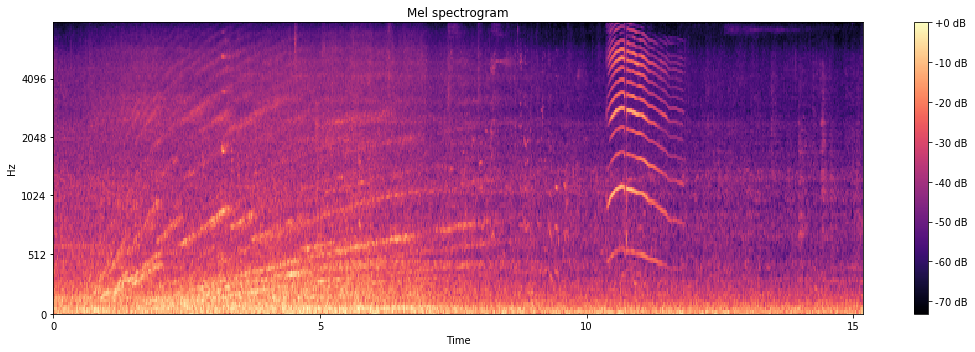

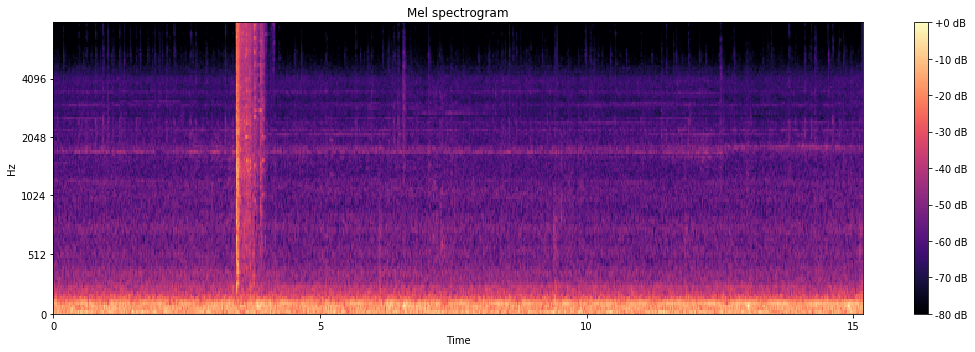

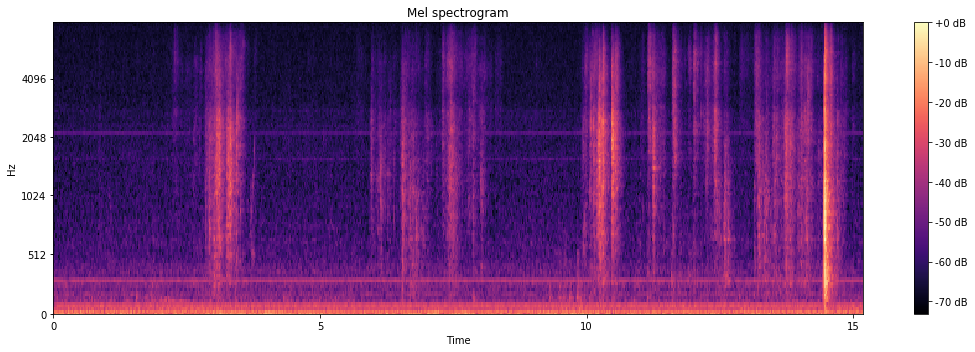

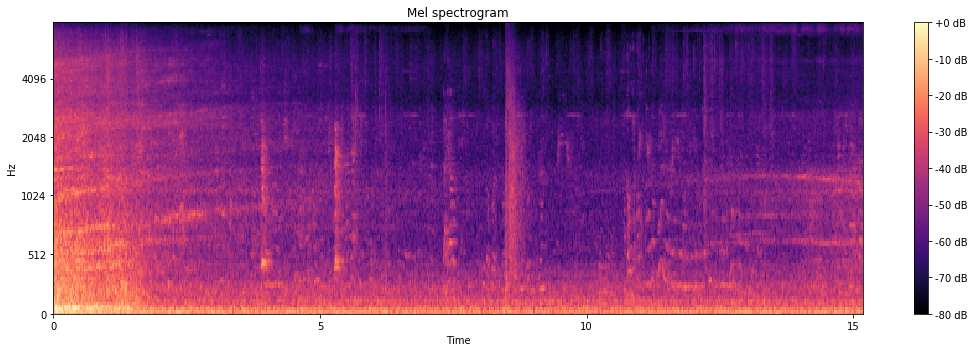

In [9]:
import matplotlib.pyplot as plt
import librosa.display
indexes = [0, 502, 1001, 1031]
for i in indexes:
  plt.figure(figsize=(15, 5))
  librosa.display.specshow(X[i],y_axis='mel', fmax=8000, x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel spectrogram')
  plt.tight_layout()
  plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D,BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [27]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5,5), strides=2, activation='relu', input_shape=(128, 654, 1)))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(5,5), strides=2, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(5,5), strides=2, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=2, activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(30, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 62, 325, 16)       416       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 162, 16)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 31, 162, 16)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 31, 162, 16)       64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 79, 32)        12832     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 39, 32)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 39, 32)         0         
__________

In [32]:
weights = {
    0:2,
    1:3,
    2:3,
    3:1
}
checkpoint = [ModelCheckpoint('model.h5', monitor='val_acc',mode='max',save_best_only=True, verbose=1)]
model.fit(X_train.reshape(X_train.shape[0], 128, 654, 1), Y_train, epochs=75, validation_split=0.1, class_weight = weights,callbacks=checkpoint)

Train on 1006 samples, validate on 112 samples
Epoch 1/75
1006/1006 [==============================] - 2s 2ms/step - loss: 0.6813 - acc: 0.8608 - val_loss: 6.1736 - val_acc: 0.6071

Epoch 00001: val_acc improved from -inf to 0.60714, saving model to model.h5
Epoch 2/75
1006/1006 [==============================] - 1s 580us/step - loss: 1.0993 - acc: 0.8052 - val_loss: 1.4890 - val_acc: 0.7679

Epoch 00002: val_acc improved from 0.60714 to 0.76786, saving model to model.h5
Epoch 3/75
1006/1006 [==============================] - 1s 553us/step - loss: 0.9009 - acc: 0.8260 - val_loss: 1.0570 - val_acc: 0.8036

Epoch 00003: val_acc improved from 0.76786 to 0.80357, saving model to model.h5
Epoch 4/75
1006/1006 [==============================] - 1s 568us/step - loss: 0.9203 - acc: 0.8449 - val_loss: 2.6705 - val_acc: 0.3571

Epoch 00004: val_acc did not improve from 0.80357
Epoch 5/75
1006/1006 [==============================] - 1s 562us/step - loss: 0.8023 - acc: 0.8588 - val_loss: 1.8603 - 

In [33]:
from keras.models import load_model
model = load_model('model.h5')
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
Y_pred_oh = model.predict(X_test.reshape(X_test.shape[0], 128, 654, 1))
Y_pred = [np.argmax(i) for i in Y_pred_oh]
Y_true = [np.argmax(i) for i in Y_test]
cm = confusion_matrix(Y_true, Y_pred)
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(cm)
print(acc)
print(f1)

[[ 47   0   3   6]
 [  1  47   6  10]
 [  1   3  43  14]
 [  1   5   9 177]]
0.8418230563002681
0.8406457476377592


In [0]:
model.save('model.h5')